In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import curve_fit #for non-linear regression
from scipy import stats #for confidence intervals
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [9.708,6]
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation test
from pandas.plotting import lag_plot
import pmdarima as pm
from pmdarima.arima import ndiffs
# !pip install pmdarima
# !pip install --upgrade scipy
import seaborn as sns
sns.set_context("talk")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_batting = pd.read_csv('Batting Data.csv')
df_batting.head()

playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...   RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...   0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...  13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...  19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...  27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...  16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   0.0  
1  1.0   4  0.0  NaN  NaN NaN NaN   0.0  
2  1.0   2  5.0  NaN  NaN NaN NaN   1.0  
3  1.0   0  2.0  NaN  NaN NaN NaN   0.0  
4  2.0   2  1.0  NaN  NaN NaN NaN   0.0  

[5 rows x 22 columns]

In [3]:
df_batting['Batting_Average'] = df_batting['H'] / df_batting['AB']
df_batting = df_batting[df_batting['AB'] >= 100] 

# null_columns=df_batting.columns[df_batting.isnull().any()]
# df_batting[null_columns].isnull().sum()

df_batting.head()

playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    SB   CS  \
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   8.0  1.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   3.0  1.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   1.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   6.0  2.0   
7  barnero01    1871      1    BS1  NaN  31  157  66  63  10  ...  11.0  6.0   

   BB   SO  IBB  HBP  SH  SF  GIDP  Batting_Average  
1   4  0.0  NaN  NaN NaN NaN   0.0         0.271186  
2   2  5.0  NaN  NaN NaN NaN   1.0         0.291971  
3   0  2.0  NaN  NaN NaN NaN   0.0         0.330827  
4   2  1.0  NaN  NaN NaN NaN   0.0         0.325000  
7  13  1.0  NaN  NaN NaN NaN   1.0         0.401274  

[5 rows x 23 columns]

In [4]:
x = df_batting['yearID']
y = df_batting['Batting_Average']

df_batting["yearID"].min(), df_batting["yearID"].max()

df_batting["yearID"].max() - df_batting["yearID"].min()

149

In [5]:
df_mean = df_batting.groupby(['yearID']).mean()
df_mean.reset_index(inplace=True)
df_mean.head()

# df_batting.index = pd.to_datetime(df_batting.yearID, format='%Y')
# df_batting.head(5)

# df_mean['Year'] = df_mean['yearID']
# df_mean.head()

df = df_mean[['yearID', 'Batting_Average']]
df.head()

df.index = pd.to_datetime(df.yearID, format='%Y')
df = df.drop('yearID', axis =1)
df.head(5)

# df_batting.index = pd.to_datetime(df_batting.yearID, format='%Y')
# df_batting.head(5)
# df1['Date'] = pd.to_datetime(df_mean[['Year']].assign(DAY = 1, MONTH = 10), errors='coerce')
# df1['Date'] = [datetime.date(d) for d in df1['Date']]

# df1.head()

df.rename(columns={'Batting_Average': 'y'}, inplace=True)
df.head()

y
yearID              
1871-01-01  0.293249
1872-01-01  0.295763
1873-01-01  0.292417
1874-01-01  0.274479
1875-01-01  0.252712

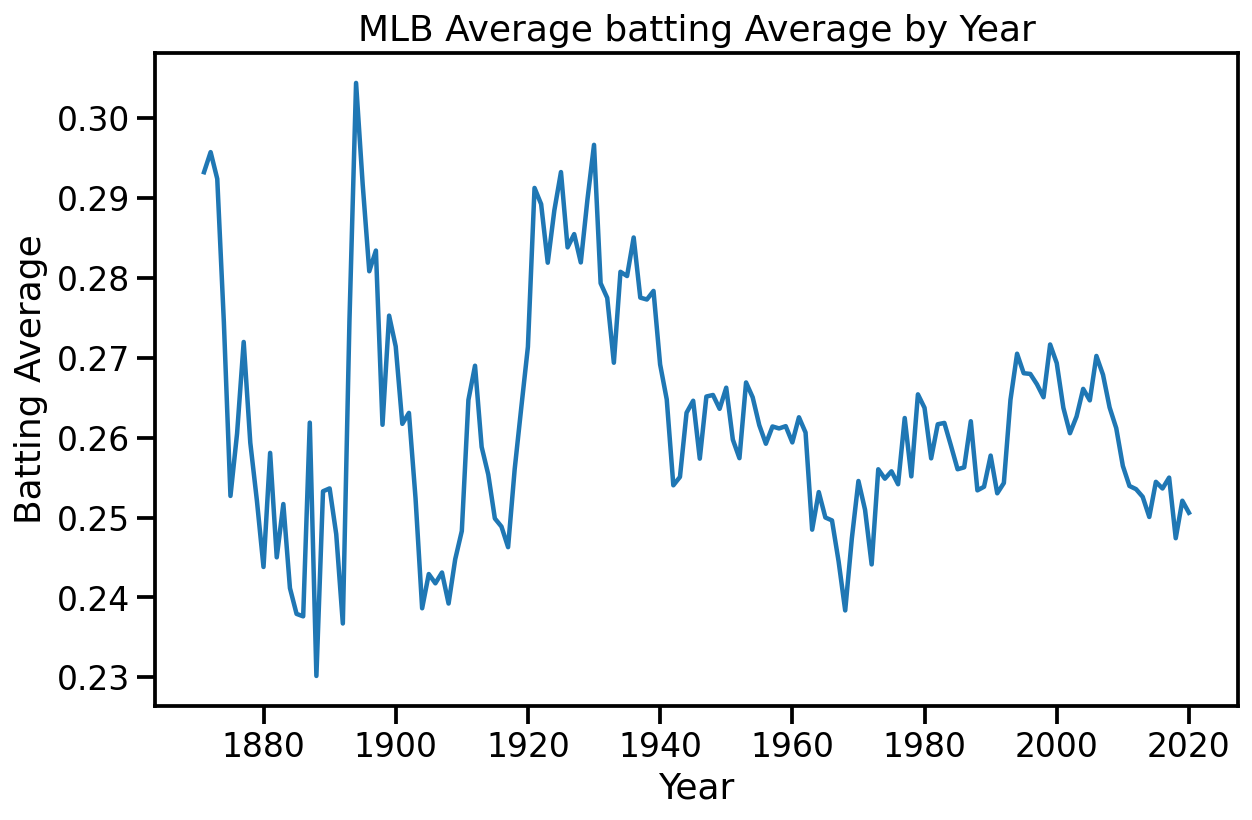

In [6]:
plt.plot(df['y'])
plt.xlabel("Year")
plt.ylabel("Batting Average")
plt.title('MLB Average batting Average by Year')
plt.show()

In [7]:
train_startdate = pd.to_datetime("1900").date()
test_startdate = pd.to_datetime("2010").date()
train = df.loc[train_startdate:test_startdate]
test  = df.loc[test_startdate:]
print("train size = %d, test size = %d, total size = %d"%(len(train),len(test),len(df)))

train size = 111, test size = 11, total size = 150


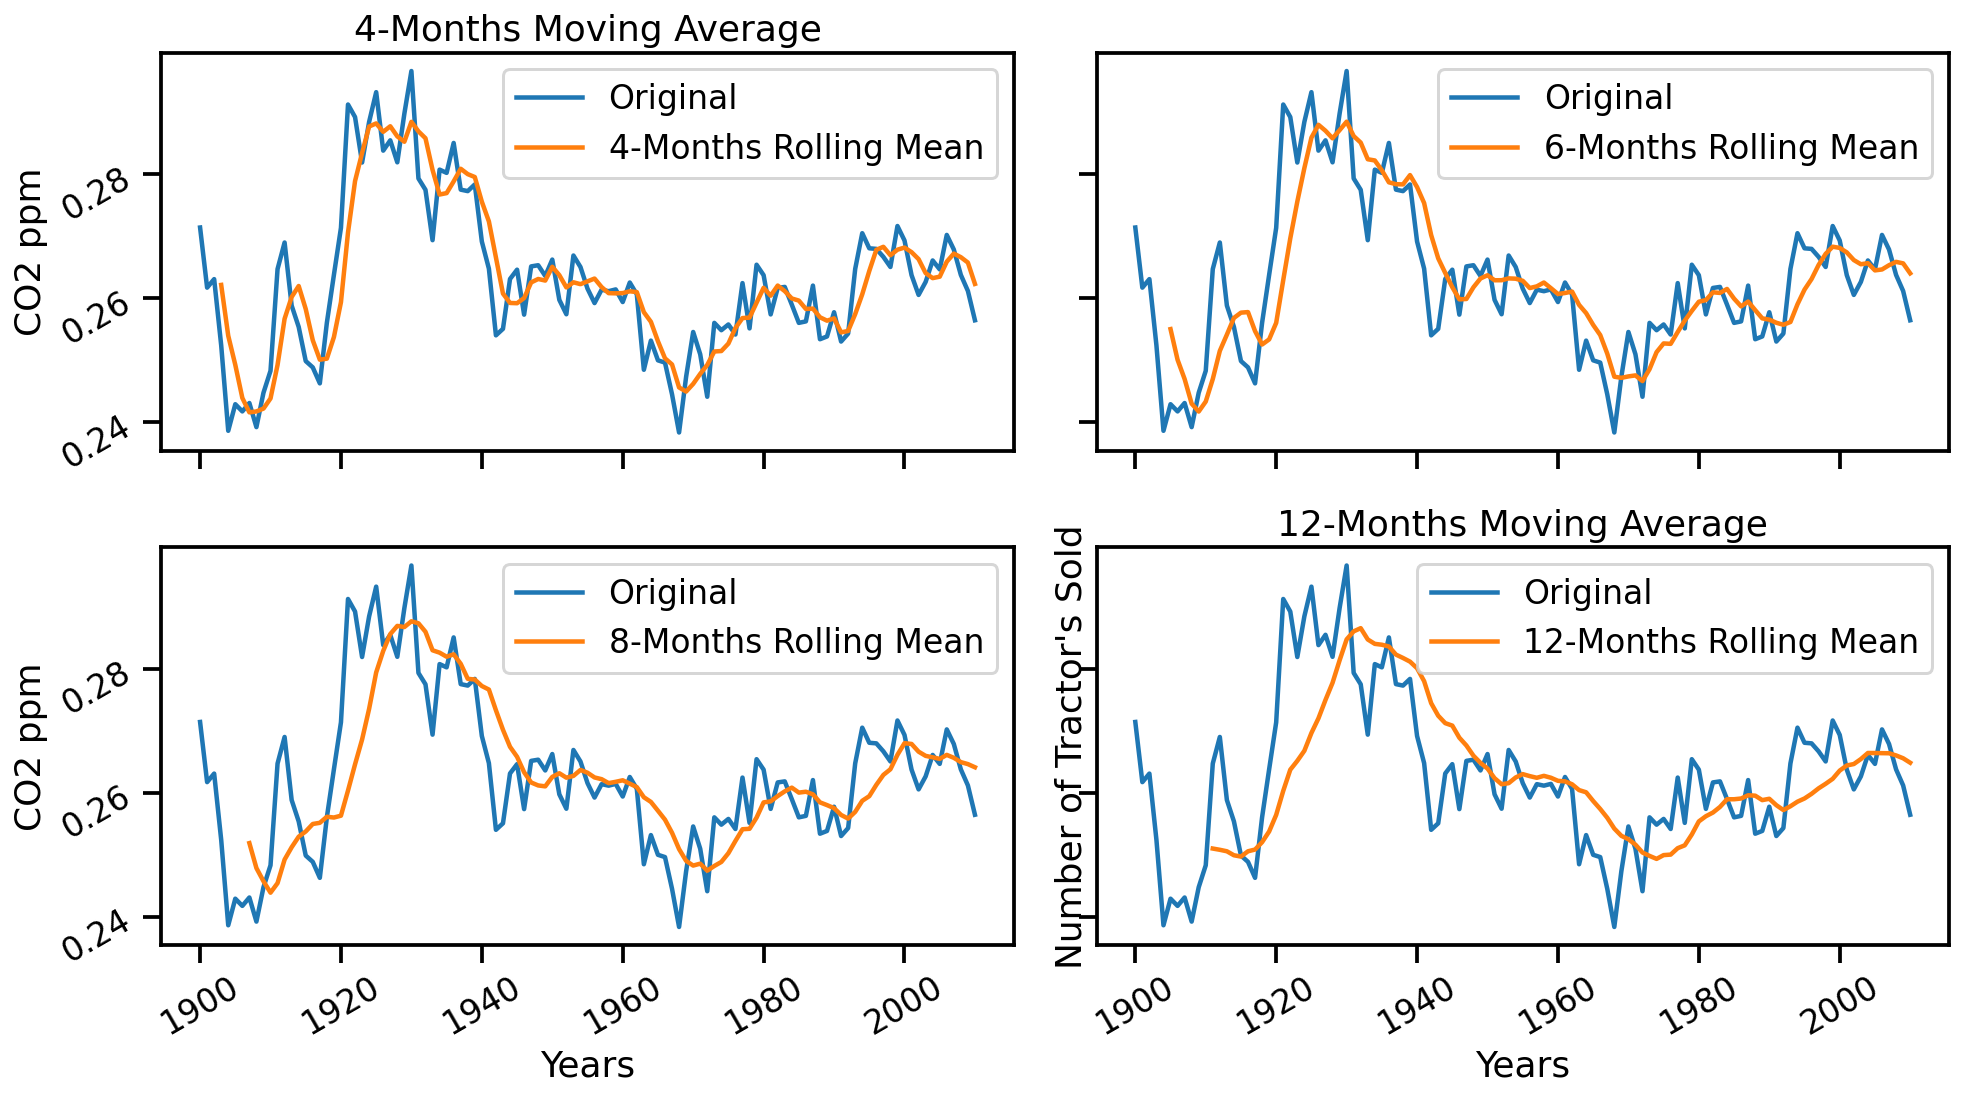

In [8]:
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True,figsize=(14,8))
axes[0][0].plot(train, label='Original')
axes[0][0].plot(train.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][0].set_ylabel("CO2 ppm")
#
axes[0][1].plot(train, label='Original')
axes[0][1].plot(train.rolling(window=6).mean(), label='6-Months Rolling Mean')
plt.title("6-Months Moving Average")
axes[0][1].legend(loc='best')
#
axes[1][0].plot(train, label='Original')
axes[1][0].plot(train.rolling(window=8).mean(), label='8-Months Rolling Mean')
plt.xlabel("Years")
plt.ylabel("Number of Tractor's Sold")
plt.title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("CO2 ppm")
#
axes[1][1].plot(train, label='Original')
axes[1][1].plot(train.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
plt.title("12-Months Moving Average")
axes[1][1].legend(loc='best')
#----- set for all axes
for ax in fig.axes:
    ax.tick_params(labelrotation=30) # Rotates X-Axis Ticks by 30-degrees
#
# plt.xlim('2000','2010');plt.ylim(360,400)
plt.tight_layout()
plt.show()

In [9]:
def test_df(timeseries):   
    #Perform Dickey–Fuller test:
    adfuller_test = adfuller(timeseries, autolag='AIC')
    dfad = pd.Series(adfuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adfuller_test[4].items():
        dfad['Critical Value (%s)'%key] = value
    print("==============================")    
    print('Results of Dickey Fuller Test:')
    print(dfad)
#maybe we want to print the kp test data
def test_kpss(timeseries):    
    #Perform kpss test
    kpss_test = kpss(timeseries,'ct')   
    dfkp = pd.Series(kpss_test[0:3], index=['KPSS Statistic','p-value','#Lags Used'])
    for key,value in kpss_test[3].items():
        dfkp['Critical Value (%s)'%key] = value 
    #Print 
    print("==============================")
    print('Results of KP Test:')
    print(dfkp)
    
#=============
#plot to help use see mean/std stationarity
def test_stationarity(timeseries):
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    #Plot rolling statistics    
    fig = plt.figure(figsize=(16,8))
    plt.subplot(211)
    plt.plot(timeseries,label='Original')
    plt.plot(movingAverage, color='red', label='MA')
    plt.legend()
    plt.subplot(212)
    plt.plot(movingSTD, color='green', label='Rolling Std Dev')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.tight_layout()
    plt.show(block=False)
    test_df(timeseries)

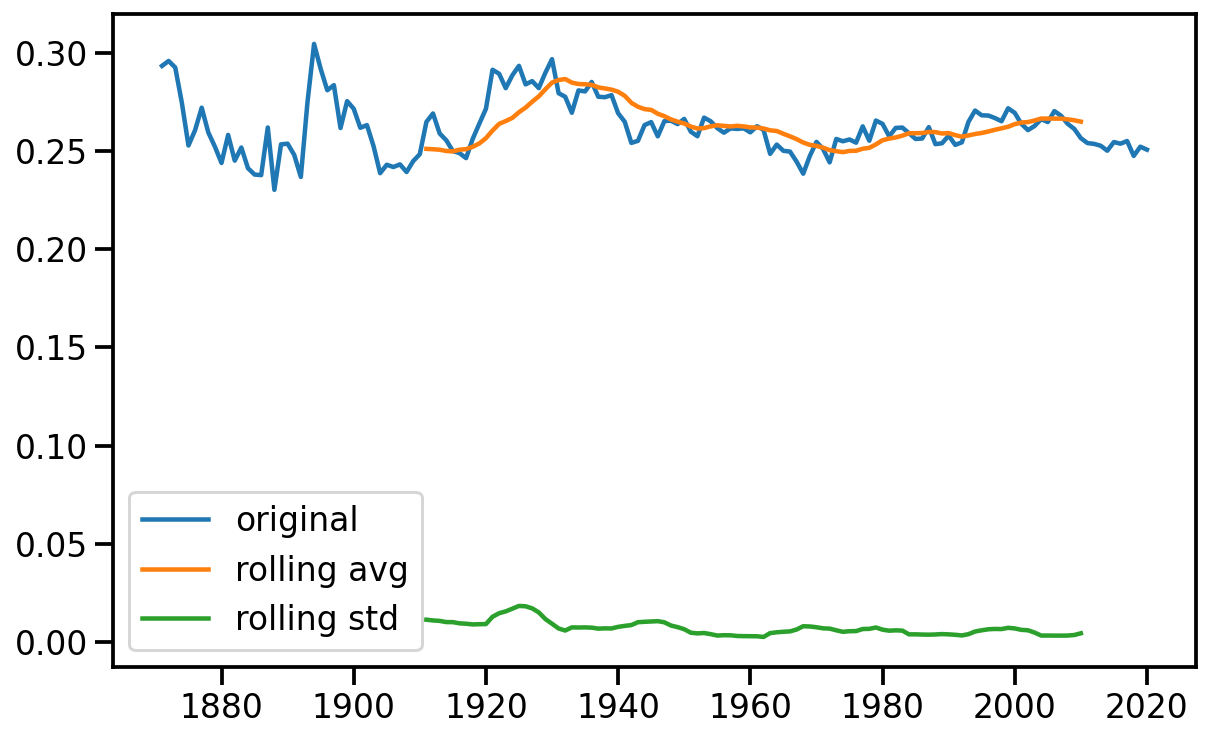

In [10]:
rollmean = train.rolling(window=12).mean()
rollstd = train.rolling(window=12).std()
rollmean.dropna(inplace=True) #need to drop NaN values where rollmean is not defined
plt.plot(df,label='original')
plt.plot(rollmean,label='rolling avg')
plt.plot(rollstd,label='rolling std')
plt.legend(loc=3)
plt.show()

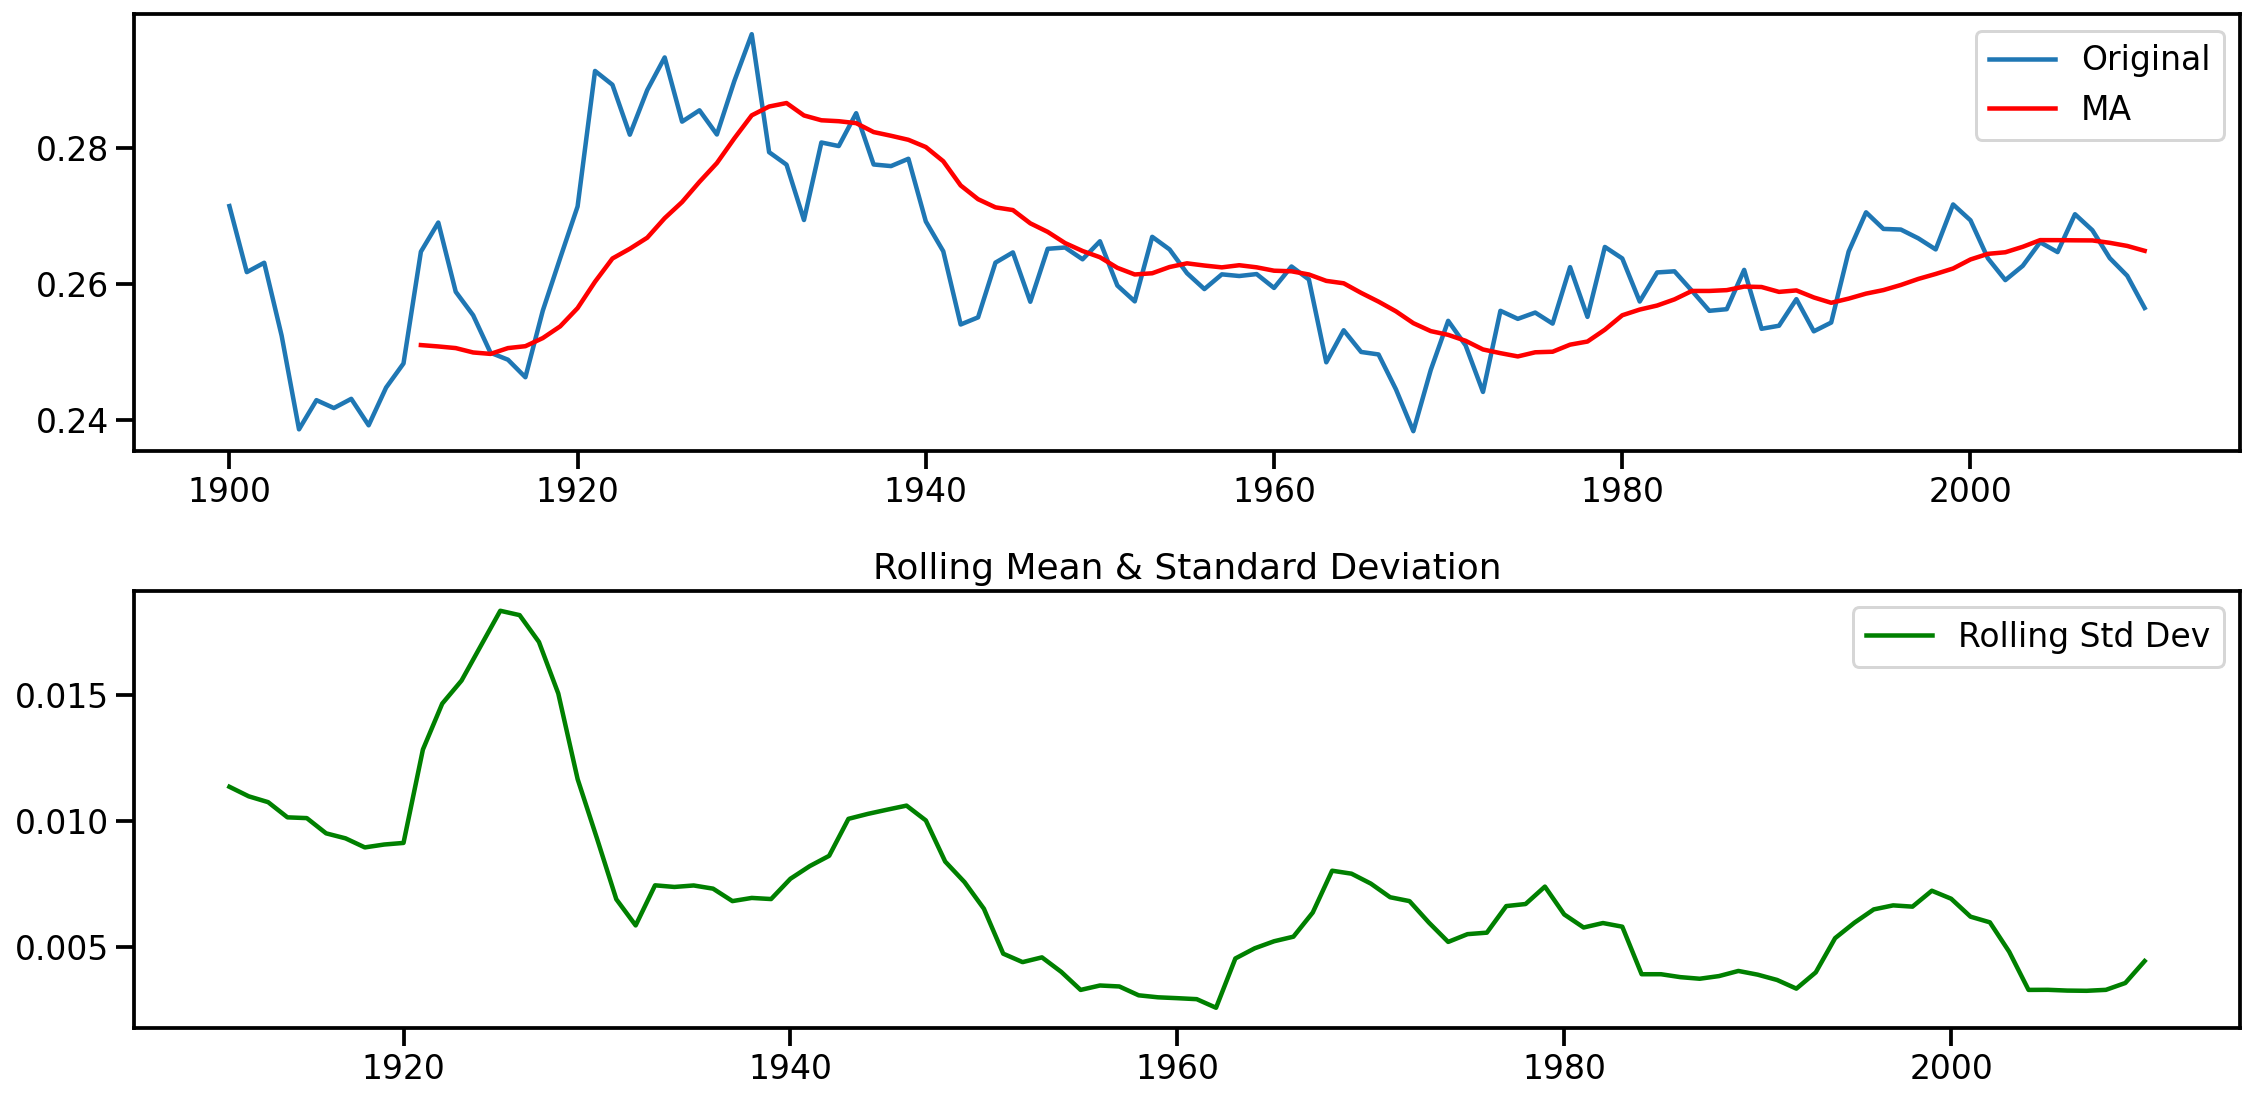

Results of Dickey Fuller Test:
Test Statistic                  -2.782635
p-value                          0.060797
#Lags Used                       0.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [11]:
test_stationarity(train)


The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1st Differencing (d=1) 
$$Y_t^\prime=Y_t−Y_{t−1}$$

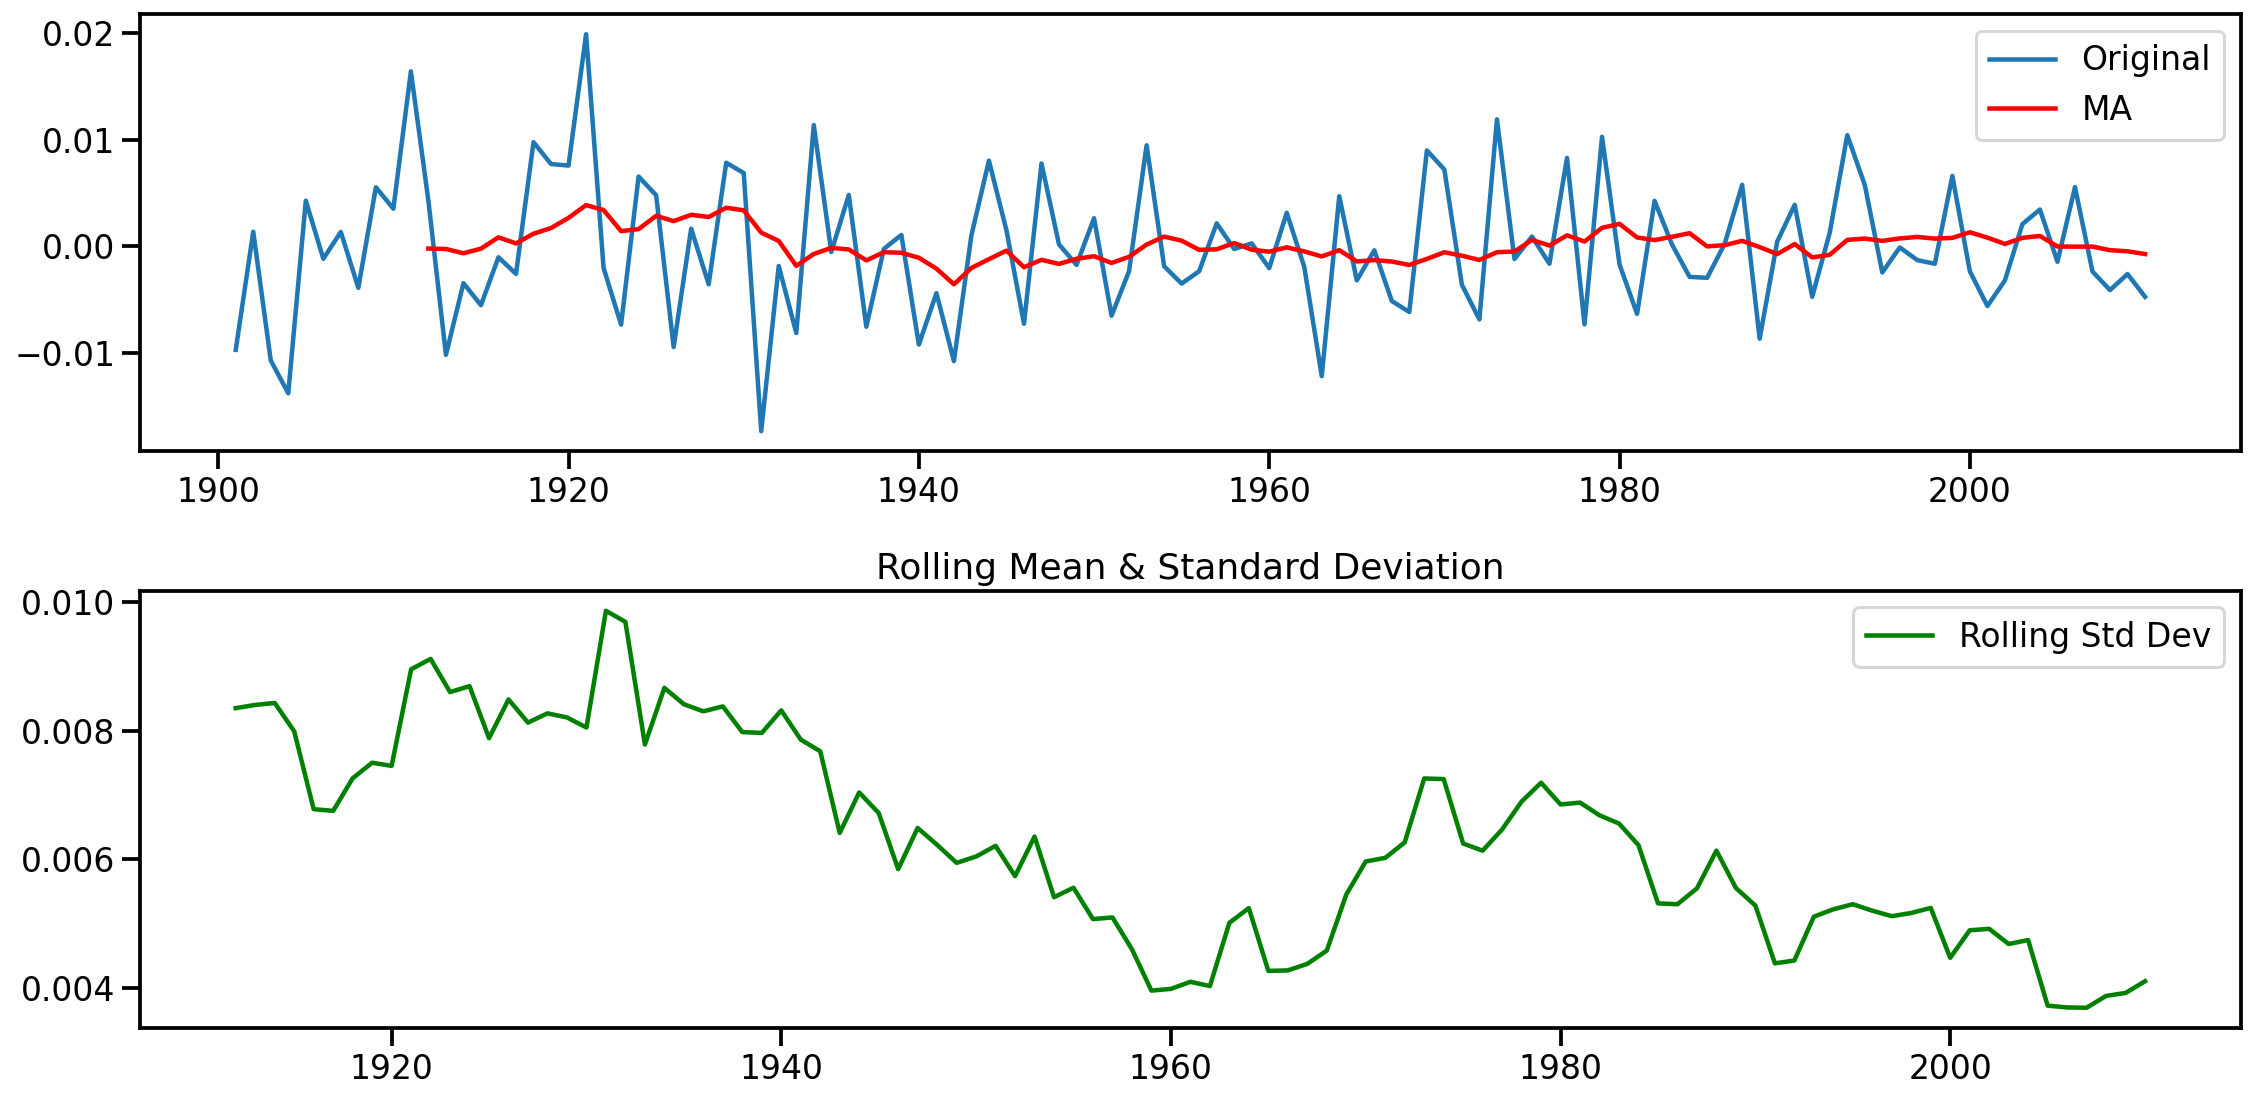

Results of Dickey Fuller Test:
Test Statistic                -1.078853e+01
p-value                        2.162826e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (1%)           -3.491818e+00
Critical Value (5%)           -2.888444e+00
Critical Value (10%)          -2.581120e+00
dtype: float64


In [12]:
train_1Diff= train - train.shift(1)
train_1Diff.dropna(inplace=True)
test_stationarity(train_1Diff)

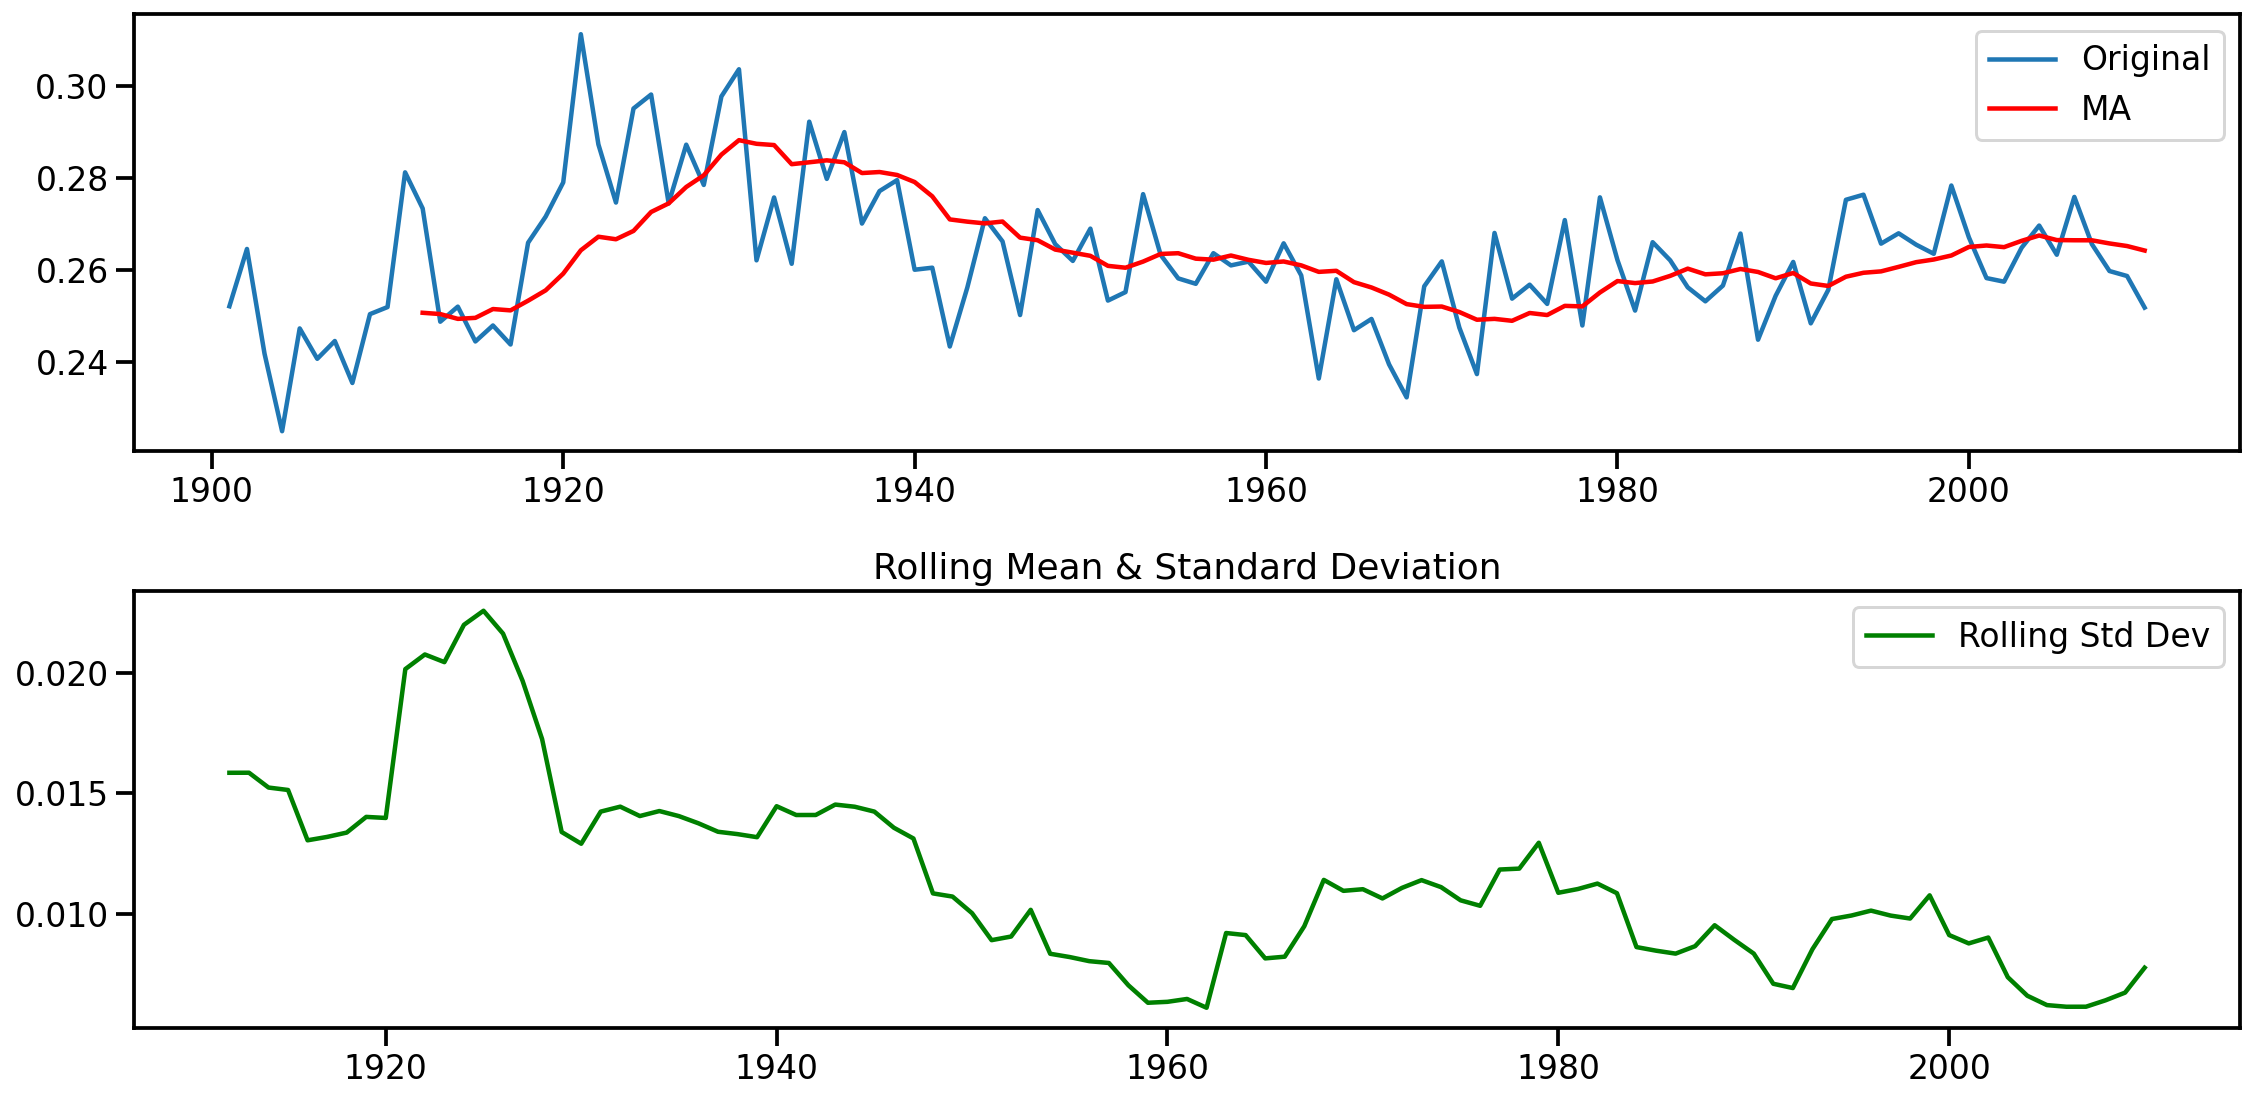

Results of Dickey Fuller Test:
Test Statistic                  -3.027460
p-value                          0.032408
#Lags Used                       2.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [16]:
train_1Diff= train + train.diff(1)
train_1Diff.dropna(inplace=True)
test_stationarity(train_1Diff)

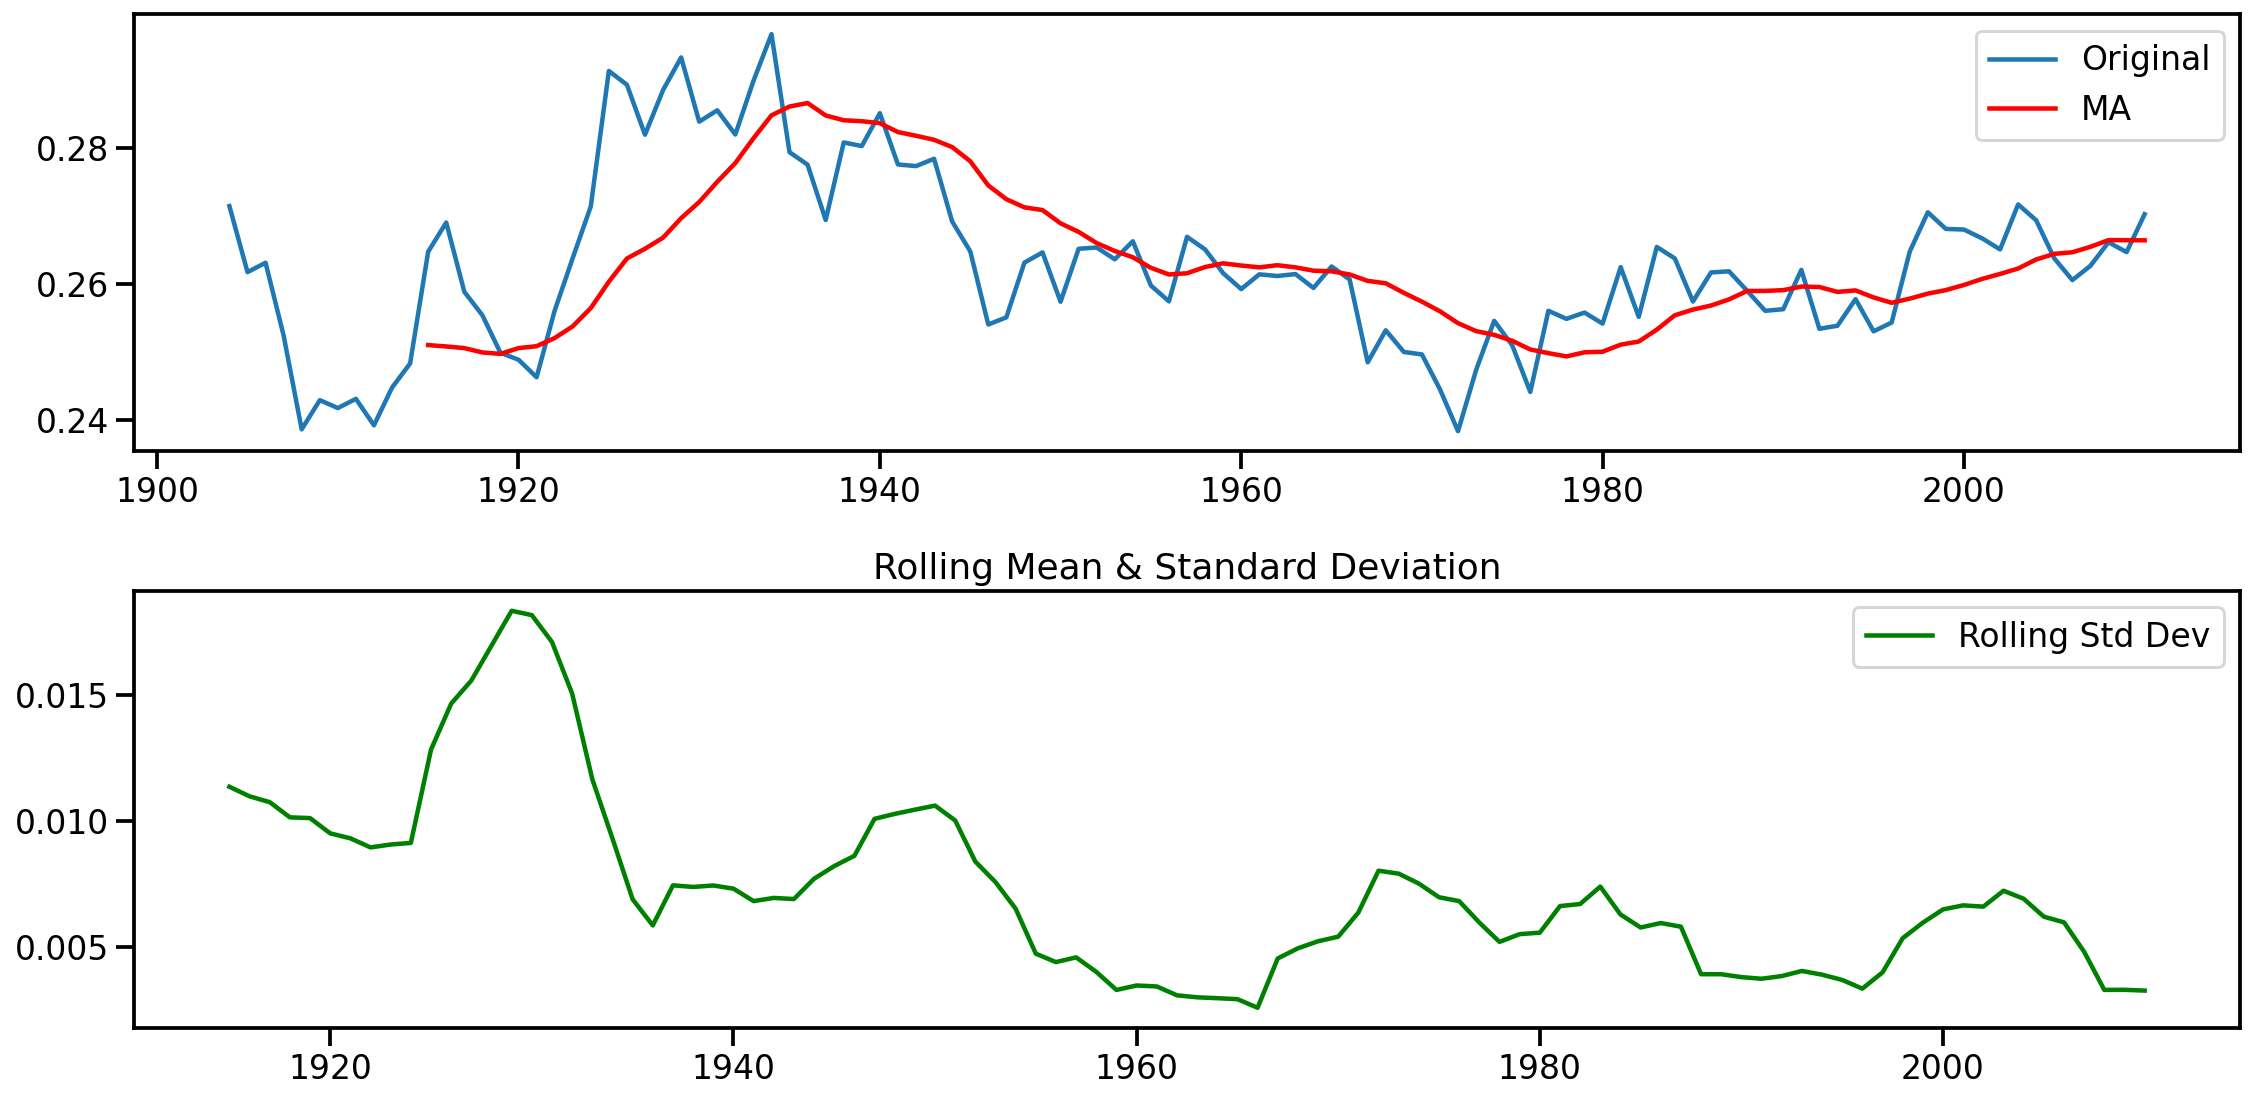

Results of Dickey Fuller Test:
Test Statistic                  -2.710344
p-value                          0.072265
#Lags Used                       0.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [33]:
train_1Diff= train - train.diff(4)
train_1Diff.dropna(inplace=True)
test_stationarity(train_1Diff)

In [0]:
df_log = np.log(train)
df_log.dropna(inplace=True)
test_stationarity(df_log)

In [0]:
df_log_1Diff= df_log - df_log.shift(1)
df_log_1Diff.dropna(inplace=True)
test_stationarity(df_log_1Diff)

In [0]:
moving_avg = df_log.rolling(window=12).mean()
df_log_ma_diff = df_log - moving_avg
df_log_ma_diff.dropna(inplace=True)
test_stationarity(df_log_ma_diff)

In [0]:
from pandas.plotting import lag_plot
fig, axes = plt.subplots(2, 3, figsize=(10, 5),sharex=True)
plt.title('Autocorrelation plot')
for lag, ax in enumerate(axes.ravel(), 1):
    lag_plot(train, lag=lag, ax=ax)
    ax.set_title(f"Lag={lag}")
plt.tight_layout()
plt.show()

In [0]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

In [0]:
xx = train.dropna()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,4), dpi= 80)
plot_acf(xx, ax=ax1, lags=24);
plot_pacf(xx,ax=ax2, lags=24);
plt.show()

p = 2, q=0, d=1

In [0]:
def evaluate_arima(timeseries, p_values, d_values, q_values):
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    #make our p,d,q
    pp,dd,qq = np.meshgrid(p_values, d_values, q_values)
    pp=pp.flatten();  dd=dd.flatten();  qq=qq.flatten()
    pdq = np.vstack((pp,dd,qq)).T    
    parameters = []
    for param in pdq:  
        try:            
            model = ARIMA(timeseries, order=param, freq = 'MS')           
            results = model.fit(disp= -1,enforce_stationarity=False,enforce_invertibility=False)
            #store data
            parameters.append([param, results.aic])
            print('ARIMA{}x{}12 - AIC:{}'.format(param, results.aic))
        except:
            continue
    result_table         = pd.DataFrame(parameters)
    result_table.columns = ['parameters','aic']
    result_table         = result_table.sort_values(by='aic',ascending = True).reset_index(drop = True) #sort by AIC
    return result_table

In [0]:
# Fit your model
model = pm.auto_arima(train,seasonal=True,m=12,
                           start_p=1, start_q=1, 
                           max_p=2,   max_q=2,
                           start_P=0, 
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,stepwise=True)

Best: ARIMA(0,1,0)x(0,1,2,12)

In [0]:
model.summary()

In [0]:
model.plot_diagnostics(figsize=(12, 8))
plt.show()

In [0]:
def getForecastOneStepArimaHelper(model):
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (fc.tolist()[0],  np.asarray(conf_int).tolist()[0])

def getForecastOneStepArima(timeseries,model):
    from copy import deepcopy
    model_new= deepcopy(model)
    pred     = []
    ci_lower = []
    ci_upper = []
    for new_ob in timeseries:
        fc, conf = getForecastOneStepArimaHelper(model_new)
        pred.append(fc)
        ci_lower.append(conf[0])
        ci_upper.append(conf[1])
        # Updates the existing model with a small number of MLE steps
        model_new.update(new_ob)
    df_pred=pd.DataFrame({'pred':pred,'ci_lower':ci_lower,'ci_upper':ci_upper})
    df_pred.index=timeseries.index
    return df_pred

def getForecastNStepsArima(model,date_range):
    Nsteps = len(date_range)
    fc, conf_int = model.predict(start=date_range[0],n_periods=Nsteps,alpha=0.05, return_conf_int=True) 
    ci       = np.asarray(conf_int)
    ci_lower = ci[:,0]
    ci_upper = ci[:,1]
    Npreds = ci.shape[0]
    df_pred=pd.DataFrame({'pred':fc,'ci_lower':ci_lower,'ci_upper':ci_upper})
    df_pred.index = date_range
    return df_pred

In [0]:
Nsteps     = len(test)
start_date = test.index[0]
end_date   = start_date + relativedelta(months=(Nsteps-1))
print(start_date,end_date)
print(len(test))
date_range = pd.date_range(start_date, end_date,freq='MS')

In [0]:
df_pred = getForecastNStepsArima(model,date_range)
print(len(df_pred))
df_pred.head()